# Why You Should Hedge Beta and Sector Exposures (Part II)
---


In the first notebook, we covered the information coefficient (IC) and effective breadth, providing yet more reasons to make as many independent bets as possible. Here we expand upon the concepts detailed there by decomposing portfolios of varying numbers of securities to further explore the effects of systematic risk.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Hedging Beta and Sector Risk is Good for Allocators

Let's work from two basic beliefs:
- You would like someone to fund your algorithm
- The institution that funds your algorithm is not going to allocate 100% of its money to you. In other words, your algorithm is one in a portfolio of algorithms.

The implication of the second belief is subtle. Why should it matter that your high Sharpe algo is part of a portfolio? The key to understanding the importance of this and what it has to do with beta and sector exposure is the following mathematical result:

**In a portfolio, stock specific risk can be diversified out while common factor risk cannot.**

<div class="alert alert-warning">
<b>TL;DR:</b> Beta and sector exposure are **common factors**, i.e., they are among a handful of risk characteristics that are shared among all stocks. Risk exposure to common factors does not diversify away in a portfolio of algos. An allocator will not be able to make a large allocation to you if your algo presents common factor risk. The combination of many algos with modest common factor risk can lead to overwhelming common factor risk at the portfolio level. Allocators do not like this. If you want to get a large capital allocation, you must have low beta and sector exposure consistently over time.
</div>

# Foundations

### Single Stock Risk Decomposition

To build intuition, let's posit a single factor model:

$$r_i = \alpha_i + \beta_i r_m + \epsilon_i$$

where $\alpha_i$ is the intercept, $\epsilon_i$ is the error, and $r_m$ is the market return. This is the Capital Asset Pricing Model (CAPM), which posits that the returns to a stock can be attributable to its beta-weighted exposure to the market and a return which is idiosyncratic to that stock. Two important assumptions here are that the $\epsilon_i$s are uncorrelated to the market and each other across stocks.

In this case, the "risk", as measured by the variance, for an individual stock is:

$$\sigma_i^2 = \beta_i^2 \sigma_m^2 + \sigma_{\epsilon_i}^2$$

A stocks variance is broken into the **common risk**, $\beta_i^2\sigma_m^2$, and **specific risk**, $\sigma_{\epsilon_i}$. **Common risk** is risk in the stock driven by market risk which is common among all stocks proportionate to the stock's beta. **Specific risk** is the risk that is unique to that individual stock.

Let's look at two examples and decompose the risk into the percent due to common factor risk.

In [2]:
def stock_risk(beta, market_vol, idio_vol):
    common_risk = (beta**2)*(market_vol**2)
    specific_risk = idio_vol**2
    total_risk = common_risk + specific_risk
    return total_risk, common_risk/total_risk

We take two separate stocks, each with different market beta exposures and idiosyncratic volatility.

In [3]:
# Betas
b1 = 1.2
b2 = 1.1
# Market volatility
market_vol = 0.15
# Idiosyncratic volatilities
idio_vol_1 = 0.10 
idio_vol_2 = 0.07

In [4]:
total_1, pct_common_1 = stock_risk(b1, market_vol, idio_vol_1)
total_2, pct_common_2 = stock_risk(b2, market_vol, idio_vol_2)

print "Stock 1 risk (annualized standard deviation): %0.4f " % np.sqrt(total_1)
print "Stock 1: percent of total risk due to common risk: %0.4f " % pct_common_1

print "\nStock 2 risk (annualized standard deviation): %0.4f " % np.sqrt(total_2)
print "Stock 2: percent of total risk due to common risk: %0.4f " % pct_common_2

Stock 1 risk (annualized standard deviation): 0.2059 
Stock 1: percent of total risk due to common risk: 0.7642 

Stock 2 risk (annualized standard deviation): 0.1792 
Stock 2: percent of total risk due to common risk: 0.8475 


This is just looking at the breakdown of the risk associated with each individual stock. We can combine these into a portfolio to see how their combined volatility is affected by common factor risk.

### Two Stock Portfolio Risk Decomposition

Now let's imagine you have a two stock portfolio with percentage weights $w_1$ and $w_2$. The risk of the portfolio (derived below), $\Pi$, under the one-factor model is then:

$$\sigma_{\Pi}^2 = \overbrace{\sigma_m^2\left( w_1^2\beta_1^2 + w_2^2\beta_2^2 + 2w_1w_2\beta_1\beta_1 \right)}^{\text{common risk}} + \overbrace{w_1^2\epsilon_1^2 + w_2^2 \epsilon_2^2}^{\text{specifc risk}}$$

This is the simplest possible example of portfolio factor risk, one factor and two assets, yet we can already use it to gain intuition about portfolio risk and hedging.

In [5]:
# The weights for each security in our portfolio
w1 = 0.5
w2 = 0.5

In [6]:
def two_stocks_one_factor(w1, w2, b1, b2, market_vol, idio_vol_1, idio_vol_2):
    common_risk = (market_vol**2)*(w1*w1*b1*b1 + w2*w2*b2*b2 + 2*w1*w2*b1*b2)
    specific_risk =  w1*w1*idio_vol_1**2 + w2*w2*idio_vol_2**2
    total_risk = common_risk + specific_risk
    return total_risk, common_risk/total_risk

The risk for a two stock, equally-weighted, long-only portfolio:

In [7]:
total, pct_common = two_stocks_one_factor(w1, w2, b1, b2, market_vol, idio_vol_1, idio_vol_2)
print "Portfolio risk (annualized standard deviation): %0.4f " % np.sqrt(total)
print "Percent of total risk due to common risk: %0.4f" % pct_common

Portfolio risk (annualized standard deviation): 0.1830 
Percent of total risk due to common risk: 0.8887


The astute reader will notice that the proportion of risk in the portfolio due to common factor risk is **larger for the portfolio** than for the weighted sum of the common risk proportion for the two components. To repeat the key point: **In a portfolio, stock specific risk diversifies while common factor risk does not.**

The risk for a two stock, beta-hedged long-short portfolio:

In [8]:
w2 = -w1*b1/b2    # set weight 2 such that the portfolio has zero beta

total, pct_common = two_stocks_one_factor(w1, w2, b1, b2, market_vol, idio_vol_1, idio_vol_2)
print "Portfolio risk (annualized standard deviation): %0.4f " % np.sqrt(total)
print "Percent of total risk due to common risk: %0.4f" % pct_common

Portfolio risk (annualized standard deviation): 0.0629 
Percent of total risk due to common risk: 0.0000


Note that we eliminated **all** the common risk with a perfect beta hedge.


# Portfolio Risk

If $X$ is a column vector of n random variables, $X_1,\dots,X_n$, and $c$ is a column vector of coefficients (constants), then the [variance of the weighted sum](https://en.wikipedia.org/wiki/Variance) $c'X$ is

$$\text{Var}(c'X) = c'\Sigma c$$

where $\Sigma$ is the covariance matrix of the $X$'s.

In our application, $c$ is our stock weight vector $w$ and $\Sigma$ is the covariance matrix of stock returns.

$$\sigma_{\Pi}^2 = w' \Sigma w$$

Just as we decompose the single stock risk above, we can decompose the covariance matrix to separate *common risk* and *specific risk*

$$\Sigma = BFB' + D$$

Thus

$$\sigma_{\Pi}^2  = w'(BFB' + D)w$$
$$\sigma_{\Pi}^2  = w'BFB'w + w'Dw$$


If you work through this matrix multiplication, you get the stated result above

$$\sigma_{\Pi}^2 = \overbrace{\sigma_m^2\left( w_1^2\beta_1^2 + w_2^2\beta_2^2 + 2w_1w_2\beta_1\beta_1 \right)}^{\text{common risk}} + \overbrace{w_1^2\epsilon_1^2 + w_2^2 \epsilon_2^2}^{\text{specifc risk}}$$

### Multi-Factor Models

Of course, we can expand the CAPM to include *additional* risk factors besides market beta. We could posit that there are in total $m$ risks which are *common* to all stocks.

$$r_i = \alpha_i + \beta_{1,i} f_1 + \dots + \beta_{m,i} f_m + \epsilon_i$$

or more concisely

$$r_i = \alpha_i + \sum_{j=1}^m \beta_{j,i} f_j + \epsilon_i$$

or, considering all stocks, $i$, from 1 to N, even more concisely, for a given period $t$,

$$r = \alpha + Bf + \epsilon$$

where $r$ is the Nx1 column vector of returns, $B$ is the Nx$m$ matrix of factor betas, $f$ is the mx1 column of factor returns, and $\epsilon$ is the Nx1 column vector of idiosyncratic returns. Finally,

$$\sigma_{\Pi}^2  = w'BFB'w + w'Dw$$

where $B$ is the Nx$m$ matrix of factor betas, $F$ is the $m$x$m$ covariance matrix of factor returns, and $D$ is a NxN matrix with the variance of $\epsilon_i$'s on diagonal, and zeros everywhere else.

With this result, *assuming we had a suitable risk model giving us the matrices $B$, $F$, and $D$*, we could calculate our portfolio risk and the proportion of risk coming from common risk.

Likewise, just as we set $w_2$ above in the two stock case to the value that neutralized the exposure to the single factor $\beta$, in the multi-factor case we could use the factor betas matrix $B$ to construct a portfolio which is neutral to **all** common factors. **A portfolio which is neutral to all common factors has zero common factor risk.**


# Portfolios of Algos

Even without a risk model, we can get some intuition as to how the risk of a portfolio of algos looks.

What does a resulting portfolio of algos look like when the individual algos have non-zero common risk? Taking some inspiration from a recent journal article [The Dangers of Diversification](http://www.iijournals.com/doi/abs/10.3905/jpm.2017.43.2.013?journalCode=jpm) by Garvey, Kahn, and Savi, imagine that each algo has a certain *budget of common risk* it can take. This budget is defined as the percent common risk of total risk in the algo.

In the first case, we assume that all algos have this same budget (and use all the budget) and the correlation between their common risks is 1.0. This is simular to the case of a single factor model.



In [9]:
def portfolio_risk_decomposition(budget=0.2, correl=1.0, algo_count=2, algo_total_risk=0.04):
    N = algo_count
    
    algo_common_risk = budget*(algo_total_risk**2)
    algo_idio_risk = algo_total_risk**2 - algo_common_risk

    w = 1./N
    
    covar = correl*algo_common_risk
    common_risk = N*w*w*algo_common_risk + (N*N - N)*w*w*covar
    idio_risk = algo_idio_risk*w
    total_risk = common_risk + idio_risk
    
    return total_risk, common_risk/total_risk

In [10]:
a, b = portfolio_risk_decomposition(budget=0.2, algo_count=20, correl=1.0, algo_total_risk=0.04)
print "Portfolio total risk: %.4f " % np.sqrt(a)
print "Portfolio percent of common risk: %.4f " % b

Portfolio total risk: 0.0196 
Portfolio percent of common risk: 0.8333 


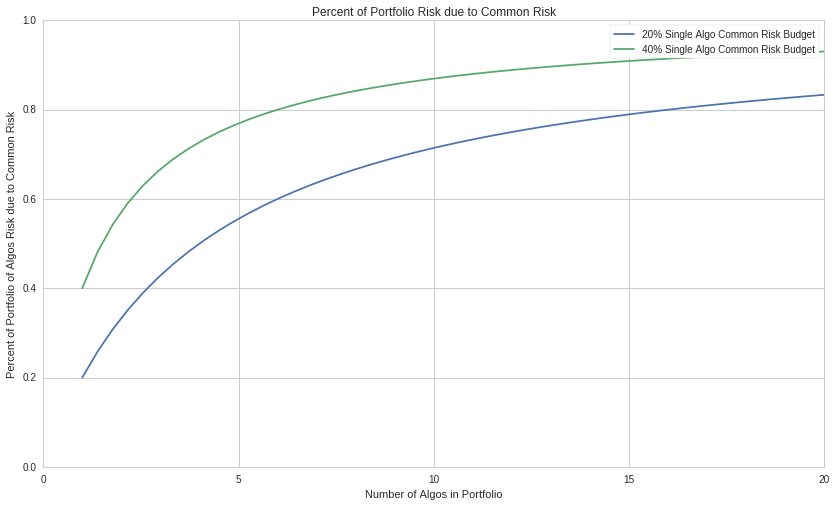

In [11]:
algos = np.linspace(1,20)
plt.plot(
    algos,
    portfolio_risk_decomposition(budget=0.2, correl=1.0, algo_count=algos)[1]
)
plt.plot(
    algos,
    portfolio_risk_decomposition(budget=0.4, correl=1.0, algo_count=algos)[1]
)
plt.ylim([0,1]);
plt.title('Percent of Portfolio Risk due to Common Risk')
plt.xlabel('Number of Algos in Portfolio')
plt.ylabel('Percent of Portfolio of Algos Risk due to Common Risk')
plt.legend(
    ['20% Single Algo Common Risk Budget', '40% Single Algo Common Risk Budget']
);

From this plot, you can see that from the allocator's perspective, a "small" budget that allows for 20% of individual algo total risk to be driven by common risk leads to a 20 algo portfolio **with 83%** of it's risk driven by common risk. Ideally an allocator wants you to have **zero common factor risk**.

<div class="alert alert-warning">
<b>TL;DR:</b> Even if you can't predict portfolio risk and don't have a risk model to decompose risk, you can form a portfolio with **zero common risk** by hedging the beta exposure to common factors. The most important common factors in the US Equity market are market beta and sector beta. Hedge your beta and be sector neutral if you want a large allocation from any allocator.
</div>